# Step 1: Importing the libraries 📚

In [ ]:
## Importing tensorflow and frequently used layers
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, \
                                    ReLU, UpSampling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

 
from tqdm.notebook import tqdm       ## Visualize progress while training
import matplotlib.pyplot as plt      ## Display images

import warnings                      ## To conrol warnings regarding image i/o

import cv2                           ## For various io operations
import numpy as np                   ## For data conversions       

# Step 2: Donwloading the Dataset 🏗️

**Helper function to download data from url and extract it to given path**

In [ ]:
def download_dataset_to_path(path, url):
    ## In case we don't have a / at end we append it
    if path[-1] != '/':
        path = path + '/'

    ## Create the path in case it isn't already there
    print("Creating path " + path + ' ...\n')
    !mkdir $path -p

    ## Fetching data from url to given path
    print('Downloading data ...\n')
    !wget $url -P $path
    
    ## Getting name of first file in the path
    files = !ls $path
    file_path = path + files[0]

    ## Unzipping the file to the same path
    print("\nExtracting files from zip ...\n")
    !unzip -q $file_path -d $path

    ## Deleting the zip to save up disk space
    print("Removing the zip to free disk space ...")
    !rm $file_path

### Downloading Content Images

For the content images we will be using COCO dataset-train2014

In [ ]:
CONTENT_URL = 'http://images.cocodataset.org/zips/train2014.zip'
CONTENT_PATH = './datasets/content/'

In [ ]:
download_dataset_to_path(CONTENT_PATH, CONTENT_URL)

Creating path ./datasets/content/ ...


--2020-06-28 05:00:19--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.78.28
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.78.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./datasets/content/train2014.zip’

train2014.zip       100%[===================>]  12.58G  38.1MB/s    in 5m 9s   

2020-06-28 05:05:29 (41.7 MB/s) - ‘./datasets/content/train2014.zip’ saved [13510573713/13510573713]


Extracting files from zip ...

Removing the zip to free disk space ...


### Downloading Syle Images

For the style images we will be using Wikiart dataset

In [ ]:
STYLE_URL = 'http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip'
STYLE_PATH = './datasets/style/'

In [ ]:
download_dataset_to_path(STYLE_PATH, STYLE_URL)

Creating path ./datasets/style/ ...


--2020-06-04 02:17:56--  http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip
Resolving web.fsktm.um.edu.my (web.fsktm.um.edu.my)... 103.18.2.145
Connecting to web.fsktm.um.edu.my (web.fsktm.um.edu.my)|103.18.2.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27301958850 (25G) [application/zip]
Saving to: ‘./datasets/style/wikiart.zip’

wikiart.zip         100%[===================>]  25.43G  7.80MB/s    in 66m 57s 

2020-06-04 03:24:55 (6.48 MB/s) - ‘./datasets/style/wikiart.zip’ saved [27301958850/27301958850]


Extracting files from zip ...

./datasets/style/wikiart/Baroque/rembrandt_woman-standing-with-raised-hands.jpg  bad CRC 3d470143  (should be 90cccc50)
  error:  invalid compressed data to inflate ./datasets/style/wikiart/Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg
Removing the zip to free disk space ...


# Step 3: Creating the Data Generator ⚙️

In [ ]:
IMG_DIM = 288          # Images will have dim 288x288
BATCH_SIZE = 16        # Batch size for training

Creating data generator that rescales the image to 0-1 by dividing by 255, and has a size of (288, 288)

In [ ]:
## Data generator for content images
content_image_generator = ImageDataGenerator(rescale=1./255)


content_data_generator = content_image_generator.\
                flow_from_directory(directory=CONTENT_PATH,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    target_size=(IMG_DIM, IMG_DIM))

In [ ]:
## Data generator for Style images
style_image_generator = ImageDataGenerator(rescale=1./255)


style_data_generator = style_image_generator.\
                flow_from_directory(directory=STYLE_PATH,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    target_size=(IMG_DIM, IMG_DIM))

### Helper funtion to get a set of both Content and Style images

In [ ]:
def get_one_mixed_batch():
    ## Getting one batch of content images
    contentX, _ = next(content_data_generator)

    ## Getting one batch of style images
    try:
        styleX, _ = next(style_data_generator)
    except:
        return get_one_mixed_batch()    ## In case there is error we try again
    
    ## If the images are having same batch size we return the pairs
    if contentX.shape[0] == styleX.shape[0]:
        return contentX, styleX
    
    ## Else we try again
    return get_one_mixed_batch()

In [ ]:
sample_content, sample_style = get_one_mixed_batch()
sample_content.shape, sample_style.shape

((16, 288, 288, 3), (16, 288, 288, 3))

### Helper function to display Image 🖼️

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
    
    plt.show()

# Step 4: Building the Model 🚧

## Setting up the prerequisites ⚗️

#### Defining the content and style layers

In [ ]:
content_layer = 'block4_conv1'    

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block3_conv2']

num_style_layers = len(style_layers)
num_style_layers

4

#### Getting VGG with pretrained weights

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


## Style Extractor Model

The style extractor returns the intermediate style layers outputs of VGG.

In [ ]:
def get_vgg_style_extractor(style_layers = style_layers):
    """ Creates a vgg model that returns a list of intermediate output values."""
    
    outputs = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    return tf.keras.Model([vgg.input], outputs)

In [ ]:
vgg_style_model = get_vgg_style_extractor()

## Encoder

Encoder outputs basically the representation of content in an image. In our case we have VGG till the final layer as encoder. The output at that layer is our representation of contents of an image. 

In [ ]:
def get_vgg_encoder(final_layer):
    outputs = vgg.get_layer(final_layer).output
    model = tf.keras.Model([vgg.input], outputs, name = 'VGG_Encoder')
    return model

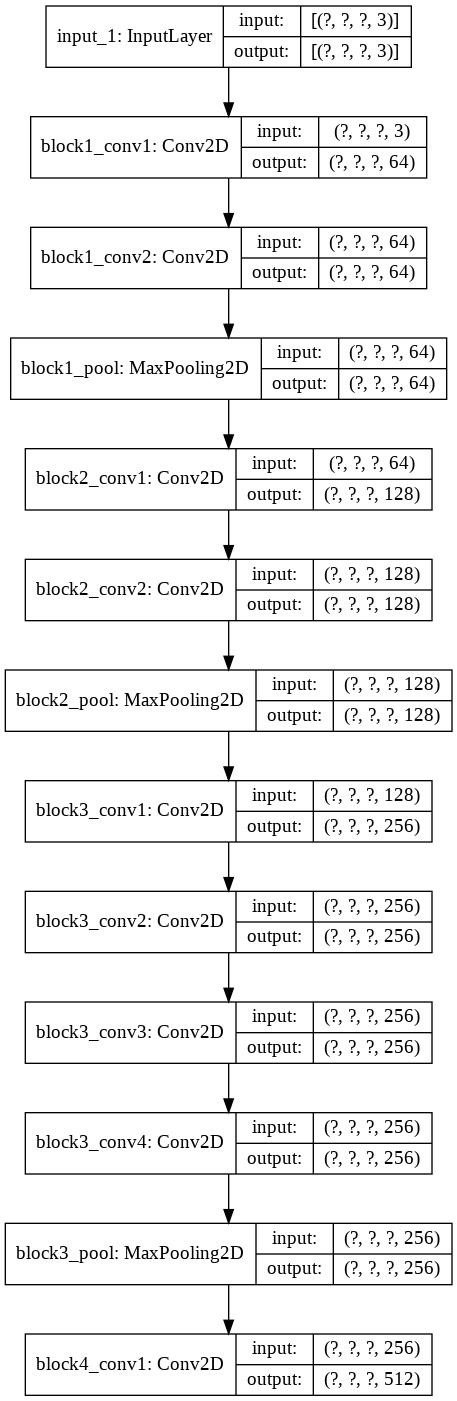

In [ ]:
encoder = get_vgg_encoder(content_layer)


tf.keras.utils.plot_model(
    encoder, to_file='VGGEncoder.png', show_shapes=True)

## Decoder

The decoder does the reverse of encoder. Its job is to output a 288x288 image given a content representation output of encoder. So, to make it easy I have created just the reverse of VGG as the decoder.

The decoder is the only part of our overall model that will be trainable.

In [ ]:
def get_decoder():
    features = tf.keras.Input(shape = (None, None, 512,), name = 'InputFeatures')

    h = Conv2D(256, (3,3), padding='same', name='Block4_Conv1')(features)
    h = ReLU()(h)

    h = UpSampling2D(size=(2,2), name = 'Upsample_3')(h)

    h = Conv2D(256, (3,3), padding='same', name='Block3_Conv4')(h)
    h = ReLU()(h)
    h = Conv2D(256, (3,3), padding='same', name='Block3_Conv3')(h)
    h = ReLU()(h)
    h = Conv2D(256, (3,3), padding='same', name='Block3_Conv2')(h)
    h = ReLU()(h)
    h = Conv2D(128, (3,3), padding='same', name='Block3_Conv1')(h)
    h = ReLU()(h)

    h = UpSampling2D(size=(2,2), name = 'Upsample_2')(h)

    h = Conv2D(128, (3,3), padding='same', name='Block2_Conv2')(h)
    h = ReLU()(h)
    h = Conv2D(64, (3,3), padding='same', name='Block2_Conv1')(h)
    h = ReLU()(h)

    h = UpSampling2D(size=(2,2), name = 'Upsample_1')(h)

    h = Conv2D(32, (3,3), padding='same', name='Block1_Conv2')(h)
    h = LeakyReLU()(h)
    h = Conv2D(3, (3,3), padding='same', name='Block1_Conv1')(h)

    return tf.keras.Model(features, h, name = 'Decoder')  

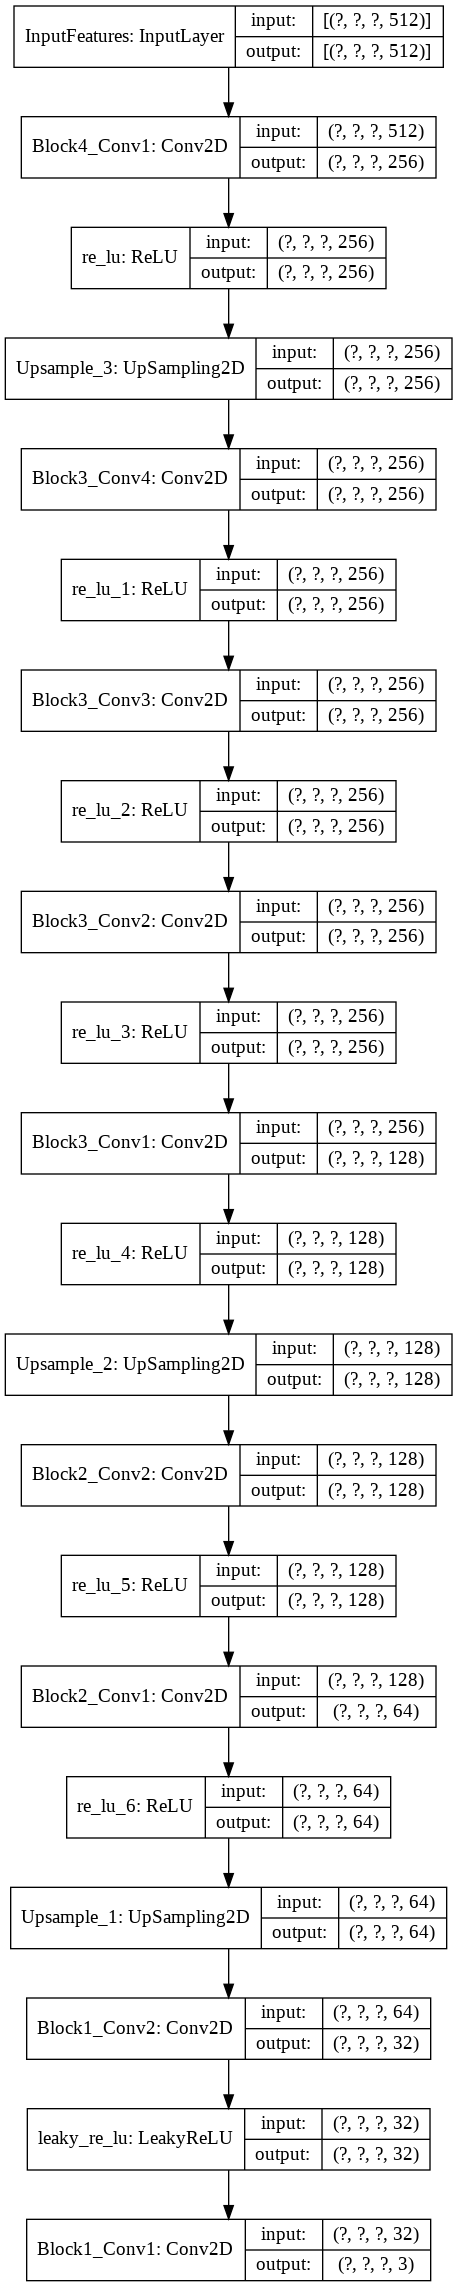

In [ ]:
decoder = get_decoder()

tf.keras.utils.plot_model(
    decoder, to_file='adaptive.png', show_shapes=True)

## Adaptive Instance Normalization Layer 💡

This is the main part of the model that does the actual Style Transfer

The following method propsed in the paper [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868) aligns the mean and variance of the content features with those of the style features making the style transfer happen in single feed forward neural network and makes it possible to be applied in realtime.

The heart of the algorithm is to modify Batch Normalization to get Adaptive Instance Normalization making the tranfer of features in content and style features.

In [ ]:
# We have an alpha parameter that can be controlled between 0-1 to set how 
# intensive is the style transfer. 1 being the highest.


def get_adaptive_instance_norm_layer(alpha=1, epsilon = 1e-5):
    ## Getting content and style features as input
    content_features = tf.keras.Input(shape=(None, None, 512), name="content_encoded")
    style_features = tf.keras.Input(shape = (None, None, 512), name = "style_encoded")

    ## Calculating mean and variance of content and style features
    content_mean, content_variance = tf.nn.moments(content_features, 
                                                   [1, 2], 
                                                   keepdims=True)
    
    style_mean, style_variance = tf.nn.moments(style_features, 
                                               [1, 2],
                                               keepdims=True)

    ## Normalizing to align mean and variance to that of style
    normalized_content_features = tf.nn.batch_normalization(
        content_features, 
        content_mean, 
        content_variance, 
        style_mean, 
        tf.sqrt(style_variance), 
        epsilon
    )

    ## Added weighted mean of style transfer and actual content features to 
    ## control the intensity of style transfer
    normalized_content_features = alpha * normalized_content_features \
                                + (1 - alpha) * content_features

    return tf.keras.Model(inputs=[content_features, style_features], 
                          outputs=normalized_content_features, 
                          name='AdaptiveInstanceNorm')

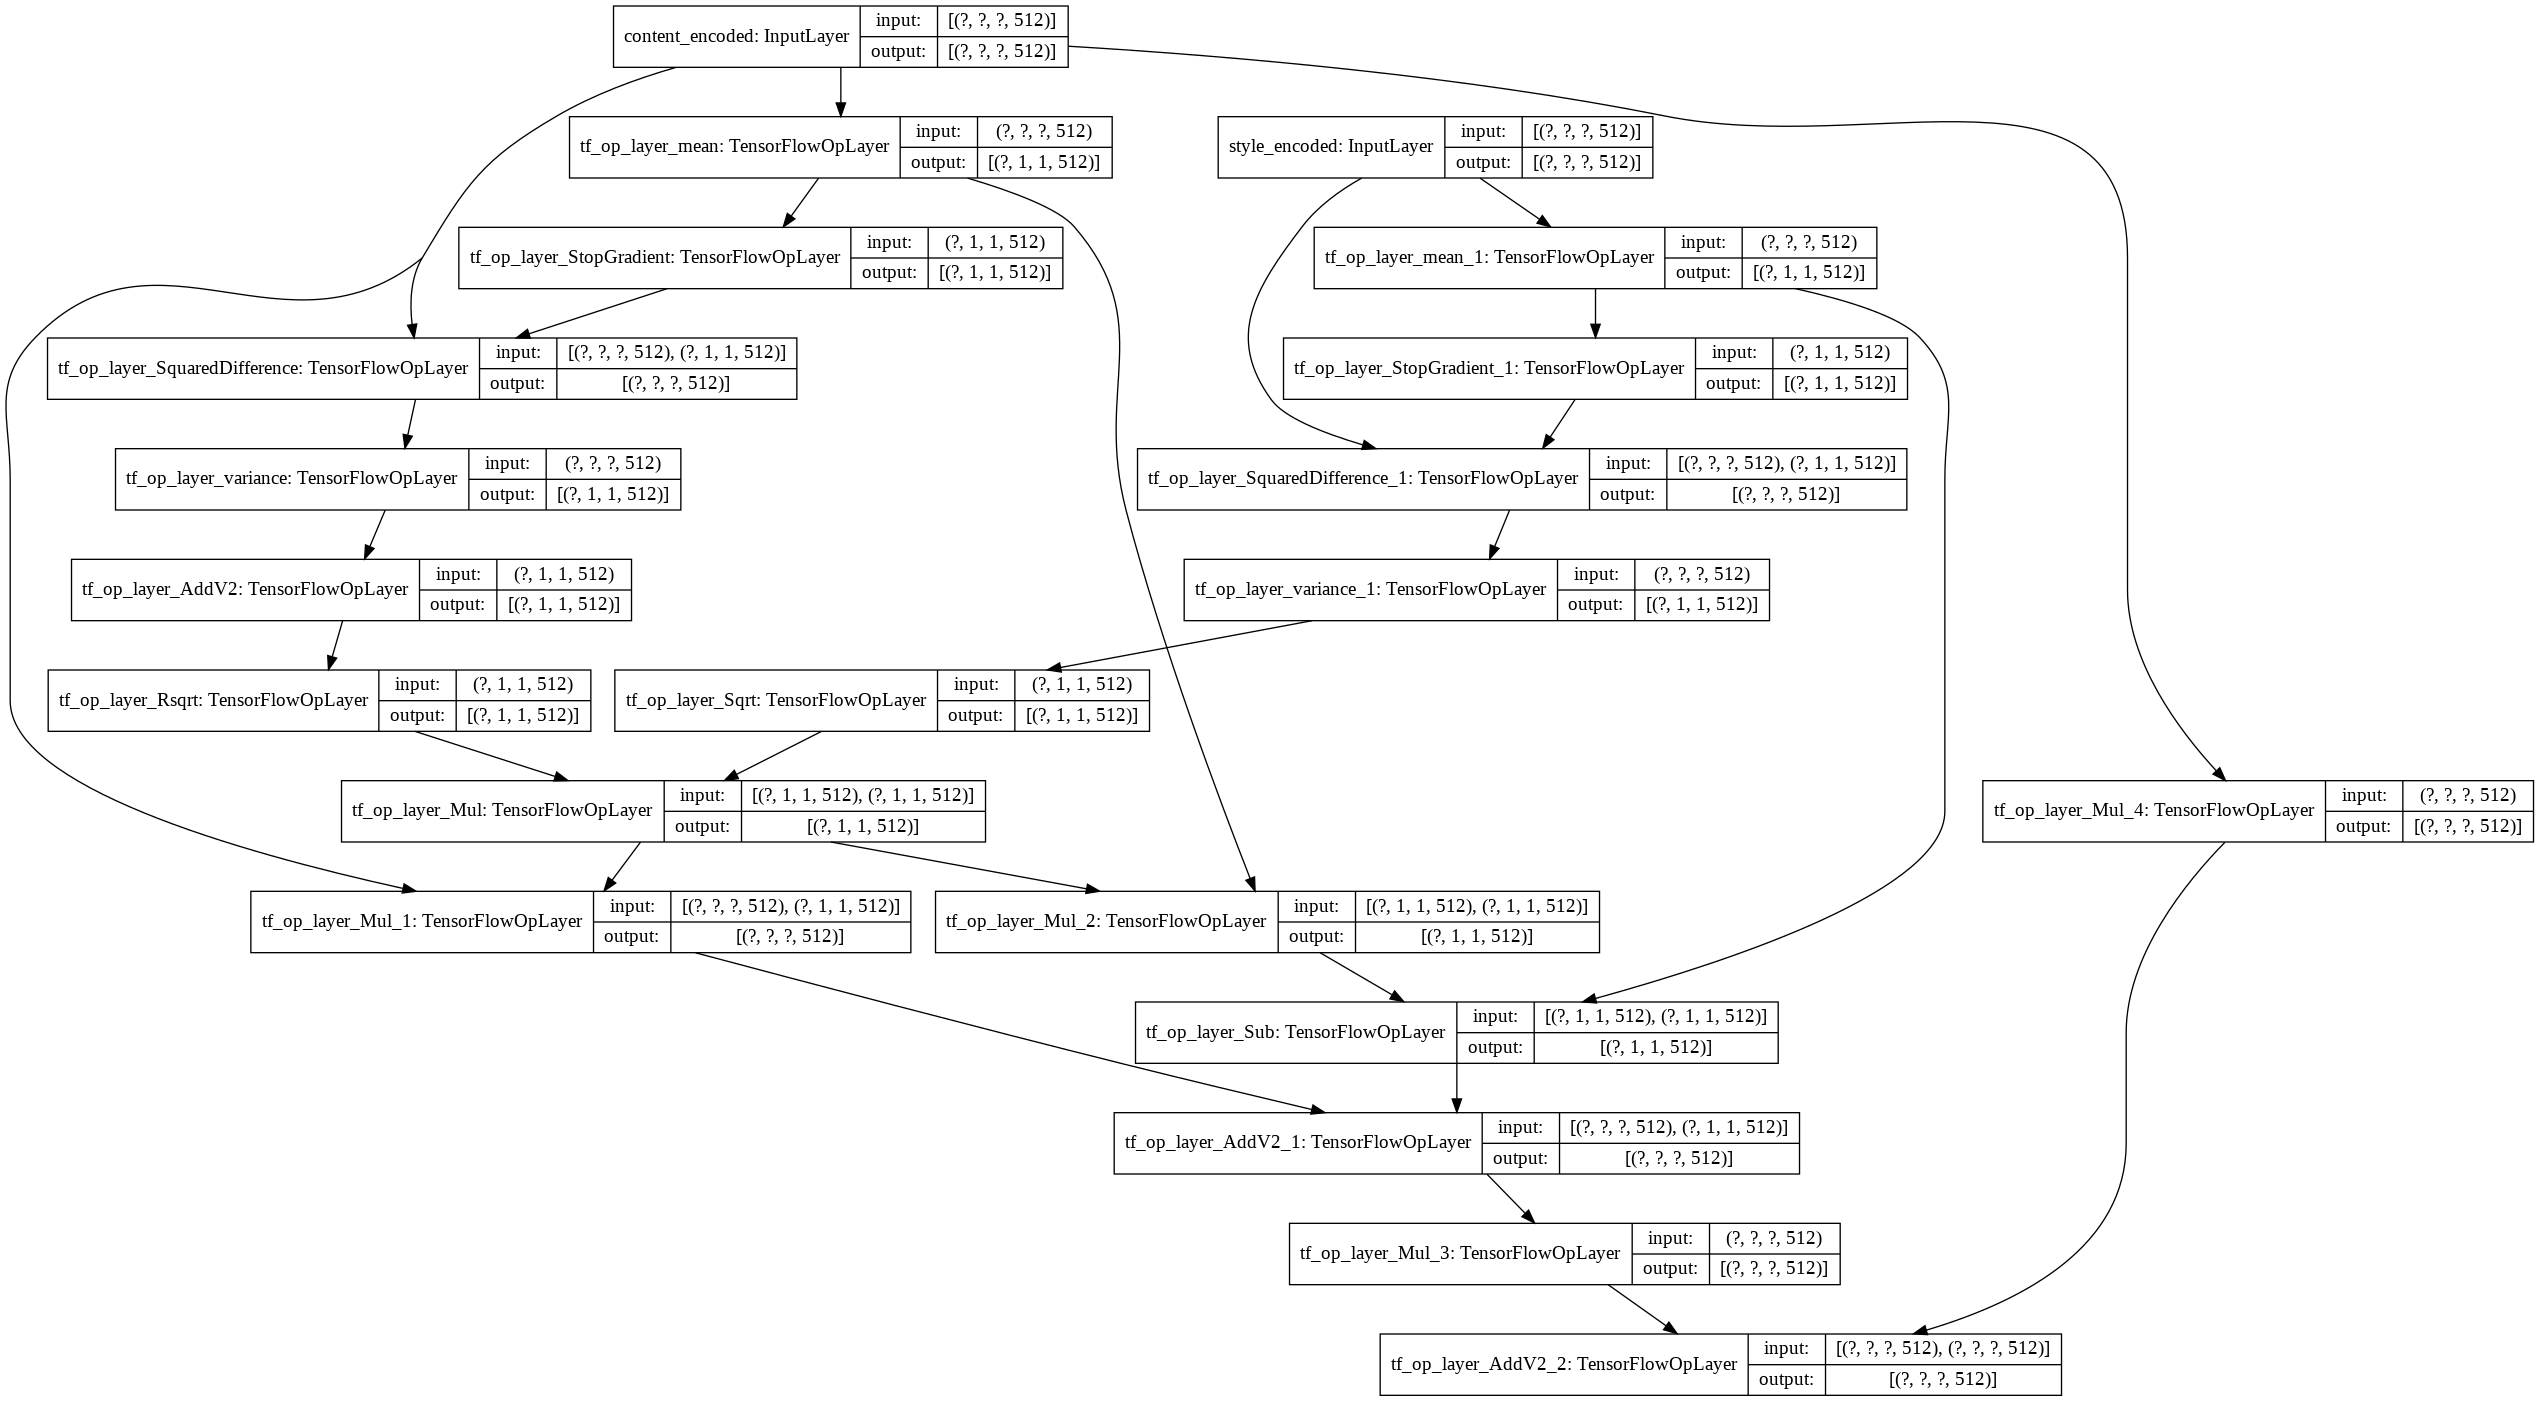

In [ ]:
sample_adaptive_instance_norm = get_adaptive_instance_norm_layer()

tf.keras.utils.plot_model(
    sample_adaptive_instance_norm, to_file='AdaptiveInstanceNorm.png', show_shapes=True)

## Arbitrary Style Transfer Model

Combining the individual components to get complete feed forward style transfer model.

In [ ]:
def get_arbitrary_style_transfer_model(encoder, decoder, alpha=1, epsilon = 1e-5):
    ## Getting content and style images as inputs
    content_images = tf.keras.Input(shape=(None, None, 3), name="content_images")
    style_images = tf.keras.Input(shape = (None, None, 3), name = "style_images")

    ## Preprocessing the content images
    content_images_scaled = content_images * 255.0
    preprocessed_content = tf.keras.applications.vgg19.preprocess_input(content_images_scaled)

    ## Passing it through encoder to get encoded representation
    content_encoded = encoder(preprocessed_content)

    ## Preprocess the style images
    style_images_scaled = style_images * 255.0
    preprocessed_styles = tf.keras.applications.vgg19.preprocess_input(style_images_scaled)

    ## Passing it through encoder to get encoded representation
    style_encoded = encoder(preprocessed_styles)

    ## Passing it through adaptive instance norm layer to get target features 
    target_features = get_adaptive_instance_norm_layer(alpha, epsilon)([content_encoded, style_encoded])

    ## Passing it through decoder to get generated images
    generated_images = decoder(target_features)

    return  tf.keras.Model(inputs=[content_images, style_images], outputs=[generated_images, target_features], name='ArbitrayStyleTransfer')

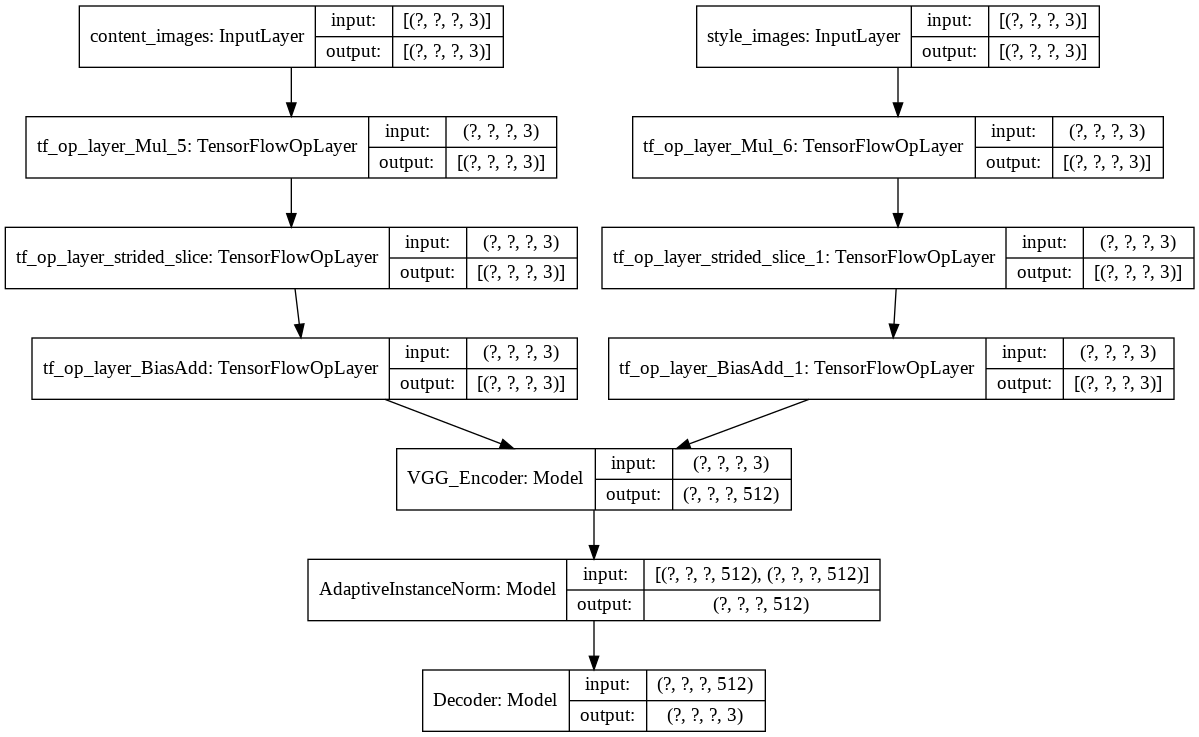

In [ ]:
model = get_arbitrary_style_transfer_model(encoder, decoder)

tf.keras.utils.plot_model(
    model, to_file='StyleTranfer.png', show_shapes=True)

In [ ]:
model.summary()

Model: "ArbitrayStyleTransfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_images (InputLayer)     [(None, None, None,  0                                            
__________________________________________________________________________________________________
style_images (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_Mul_5 (TensorFlowOp [(None, None, None,  0           content_images[0][0]             
__________________________________________________________________________________________________
tf_op_layer_Mul_6 (TensorFlowOp [(None, None, None,  0           style_images[0][0]               
______________________________________________________________________________

# Step 5: Loss function and Optimizer 📊


### Loss function

Helper function to style loss for given set of style images and corresponsing model output images

In [ ]:
def compute_style_loss(style_image, generated_image):
    style_features_in_style_image = vgg_style_model(style_image)
    style_features_in_gen_image = vgg_style_model(generated_image)

    style_layer_loss = []
    for style_feat, gen_feat in zip(style_features_in_style_image ,style_features_in_gen_image):
        meanS, varS = tf.nn.moments(style_feat, [1,2])
        meanG, varG = tf.nn.moments(gen_feat, [1,2])

        sigmaS = tf.sqrt(varS + 1e-5)
        sigmaG = tf.sqrt(varG + 1e-5)

        l2_mean = tf.reduce_sum(tf.square(meanG - meanS))
        l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

        style_layer_loss.append(l2_mean + l2_sigma)

    return tf.reduce_sum(style_layer_loss)

Loss function that returns sum of content and style loss with style weight of 2

In [ ]:
def compute_loss(inputs, outputs):
    content_image, style_image = inputs
    generated_image, features = outputs

    ## Finding the content loss
    generated_images_scaled = generated_image * 255.0
    preprocessed_gen = tf.keras.applications.vgg19.preprocess_input(generated_images_scaled)
    gen_encoded = encoder(preprocessed_gen)

    content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(gen_encoded - features), axis = [1,2]))

    ## Finding the style loss
    style_loss = compute_style_loss(style_image, generated_image)
    
    return content_loss + style_loss * 2.0

### Optimizer

In [ ]:
opt = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0.99, epsilon=1e-1)

### Testing the loss function

In [ ]:
content_batch, style_batch = get_one_mixed_batch()
inputs = [content_batch, style_batch]
outputs = model(inputs, training = False)
compute_loss(inputs, outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=2668755500000000.0>

Also we see that right now our model is just generating random image hence loss is very high

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


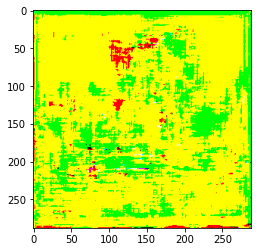

In [ ]:
gen_images = outputs[0]
imshow(gen_images[1])

# Step 6: Helper functions for Traning 📝

### Helper functions for saving and loading weights

In [ ]:
## Path where weights are to be saved
STYLE_CHECKPOINT_PATH = "./Weights/Style"

!mkdir -p $STYLE_CHECKPOINT_PATH

In [ ]:
def save_style_weights(model, epoch, path = STYLE_CHECKPOINT_PATH):
    model.save_weights(path + '/weigths{:06d}.h5'.
                     format(epoch))
    print('Saved weights for epoch {}'.format(epoch))

In [ ]:
def load_style_weights(epoch, model = decoder, path = STYLE_CHECKPOINT_PATH):
    model.load_weights(path + '/weigths{:06d}.h5'.
                     format(epoch))
    print('Loaded weights for epoch {}'.format(epoch))

### One train step

In [ ]:
@tf.function()
def train_step(content_images, style_images):
    with tf.GradientTape() as tape:
        outputs = model([content_images, style_images])
        loss = compute_loss([content_images, style_images], outputs)

    grad = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# Training : Let the learning begin 🧠

In [ ]:
START_EPOCH = 0
END_EPOCH = 1000

In [ ]:
batch_count = len(style_data_generator)
warnings.filterwarnings('ignore')

for epoch in range(START_EPOCH, END_EPOCH):
    print("Epoch => ", epoch)
    for i in tqdm(range(batch_count)):
        ## Getting one batch of content and style
        content_batch, style_batch = get_one_mixed_batch()

        ## Taking one train step
        loss = train_step(content_batch, style_batch)

        if i % 1000 == 0:
            print('Batch ', i, ' Loss: ', loss)

    ## Saving every 5th epoch's weight                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    if epoch % 5 == 0:
      save_style_weights(decoder, epoch)

# Step 7: Viewing the images generated by model 👀

Helper function to get image in the desired shape and scale from a given file path

In [ ]:
def open_file(file):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    image = image / 255.
    image = cv2.resize(image, (288, 288))
    return image.astype(np.float32)

Helper function to save a image to the given file path

In [ ]:
def save_file(image_to_save, file_path):
    image_to_save = image_to_save.numpy()
    image_to_save[np.where(image_to_save > 1)] = 1
    image_to_save[np.where(image_to_save < 0)] = 0
    image_to_saveasint = (image_to_save * 255).astype(np.uint8)
    cv2.imwrite(file_path, cv2.cvtColor(test[0], cv2.COLOR_RGB2BGR))

Getting the content and style image

In [ ]:
content_image = open_file('./tower.jpg')
style_image = open_file('./paing.jpg')

Getting the output style image generated

In [ ]:
generated_style_image, _ = model([content_image, style_image])

Viewing the results

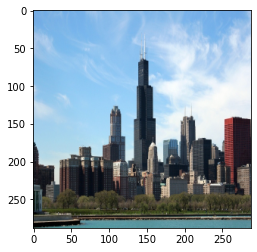

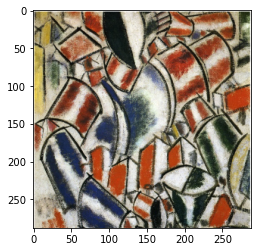

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


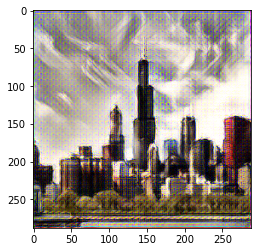

In [ ]:
imshow(content_image)
imshow(style_image)
imshow(generated_style_image)

Saving the output image

In [ ]:
save_image(generated_style_image, './output.png')